Import libraries & data

In [342]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.linear_model import Lasso, LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.preprocessing import PolynomialFeatures

In [343]:
X_train = pd.read_csv('datasets/X_train.csv')
X_test = pd.read_csv('datasets/X_test.csv', )
y_train = pd.read_csv('datasets/y_train.csv')
X_train.shape, y_train.shape, X_test.shape, 

((2051, 354), (2051, 1), (878, 354))

---
# Modeling

### MLR

cvs: [-1.40870476  0.69543129 -0.98129803  0.79905118  0.69487466]


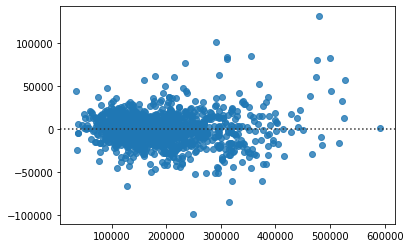

In [350]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_train, y_train, random_state=118)
ols = LinearRegression()
ols.fit(Xs_train, ys_train)
print('cvs:', cross_val_score(ols, Xs_test, ys_test, cv=5))

ys_pred = ols.predict(Xs_train)
sns.residplot(y_pred, ys_train, label='basic');

CVS looks terrible. We can do better. Let's try Ridge...

### Ridge

In [351]:
# scale
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [360]:
# Manual alpha
ridge = Ridge(alpha=3)
ridge.fit(Z_train, y_train)
print('a = 3 (manual)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5))

a = 3 (manual)
cvs: 0.882949711615742 (mean)
cvs: [0.89057776 0.92055712 0.88706849 0.89412199 0.8224232 ]


Starting to look better. But that was with a manual alpha val. Let's see if RidgeCV can find a better one...

In [359]:
# Using Matt's example logspace
ridge_alphas = np.logspace(1,3,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
print(f'a = {ridge_cv.alpha_} (found)') 
print('cvs:', cross_val_score(ridge_cv, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge_cv, Z_train, y_train, cv=5))

a = 107.22672220103232 (found)
cvs: 0.8908723277022336 (mean)
cvs: [0.89707189 0.92702518 0.8699353  0.90059003 0.85973923]


In [367]:
# Check another manual alpha for kicks
ridge = Ridge(alpha=1200)
ridge.fit(Z_train, y_train)
print('a = 1200 (manual)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Z_train, y_train, cv=5))

a = 1200 (manual)
cvs: 0.8903145084630228 (mean)
cvs: [0.90521748 0.91987818 0.86370549 0.90603482 0.85673656]


**How does my T/T split affect the alpha generated in Ridge CV**

In [368]:
for ttseed in [13, 42, 55, 80]:
    # t/t split
    Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=ttseed)
    # ridge
    ridge_cv = RidgeCV(alphas=np.logspace(1.5,2.5,100), scoring='r2', cv=5)
    ridge_cv.fit(Zs_train, ys_train)
    train_score = ridge_cv.score(Zs_train, ys_train)
    test_score = ridge_cv.score(Zs_test, ys_test)
    alpha = ridge_cv.alpha_
    print(f'TT seed: {ttseed} | train r2: {train_score} | test r2: {test_score} | alpha = {alpha}')

TT seed: 13 | train r2: 0.9373009275416753 | test r2: 0.8809540113114069 | alpha = 316.22776601683796
TT seed: 42 | train r2: 0.9369251770259555 | test r2: 0.9098833224541835 | alpha = 189.57356524063755
TT seed: 55 | train r2: 0.9351134677580493 | test r2: 0.8905978978276711 | alpha = 316.22776601683796
TT seed: 80 | train r2: 0.9409584799257829 | test r2: 0.9069873567525825 | alpha = 90.06280202112787


In [452]:
def plot_ridge_alphas(rs_range, rs_count, a_range, a_step, y_lim=[.75, 1], np_seed=42, vlines=False, legend=True ):
    plt.figure(figsize=(16,8))
    np.random.seed(np_seed)
    for seed in np.random.randint(0, rs_range, rs_count):
        x = []
        y = []
        for a in range(1, a_range, a_step):   # int list
       # for a in np.logspace(.9, , 100):    # np.log
            x.append(a)
            Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=seed)
            ridge = Ridge(alpha=a)
            ridge.fit(Zs_train, ys_train)
            test_score = ridge.score(Zs_test, ys_test)
            y.append(test_score)
        plt.plot(x, y,
                 marker='.',
                 label=seed)
        if vlines==True:
            plt.axvline(x[y.index(max(y))])
    plt.ylim(y_lim)
    plt.ylabel('Test R2', fontsize=14)
    plt.xlim(0, a_range)
    plt.xlabel('.alpha_', fontsize=14)
    if legend==True:
        plt.legend(loc='upper right', title='t-t r split seed');

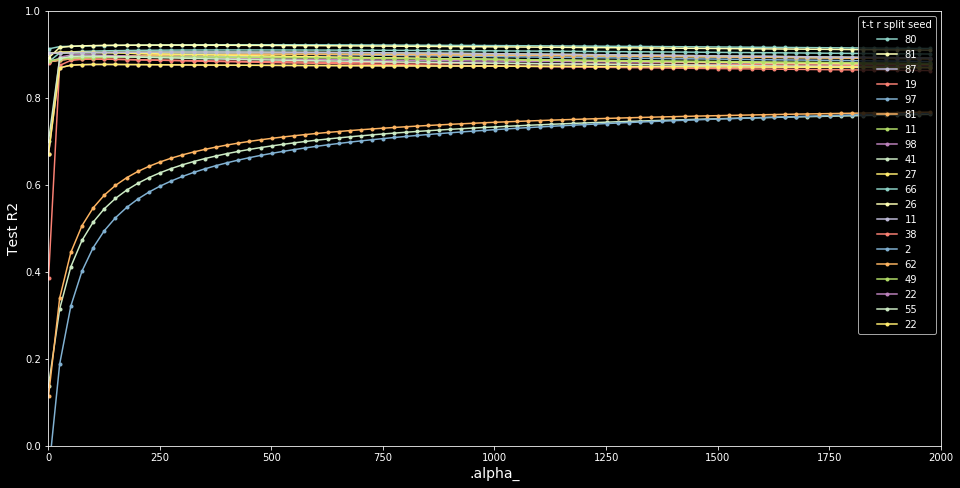

In [453]:
plot_ridge_alphas(100, 20, 2000, 25, y_lim=[0, 1], np_seed=117)

Let's run RidgeCV with every t/t seed between 0-100 to see where they congregate...

In [1]:
# get alphas for ridgeCV in seed range 0-1000
alphas = pd.read_csv('datasets/ttseed_alphas_1k.csv')

NameError: name 'pd' is not defined

Text(0, 0.5, 'count')

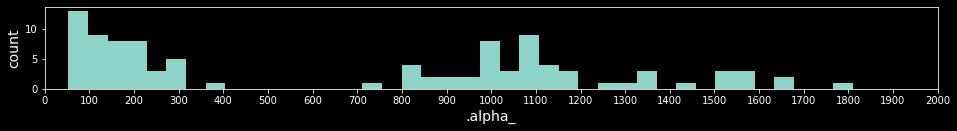

In [458]:
plt.figure(figsize=(16,4))
plt.xlim(0, 2000)
plt.hist(alphas['0'], bins=40, );
plt.xticks(range(0, 2100,100));
plt.xlabel('.alpha_', fontsize=14)
plt.ylabel('count', fontsize=14)

Zooming in 0 < α < 100

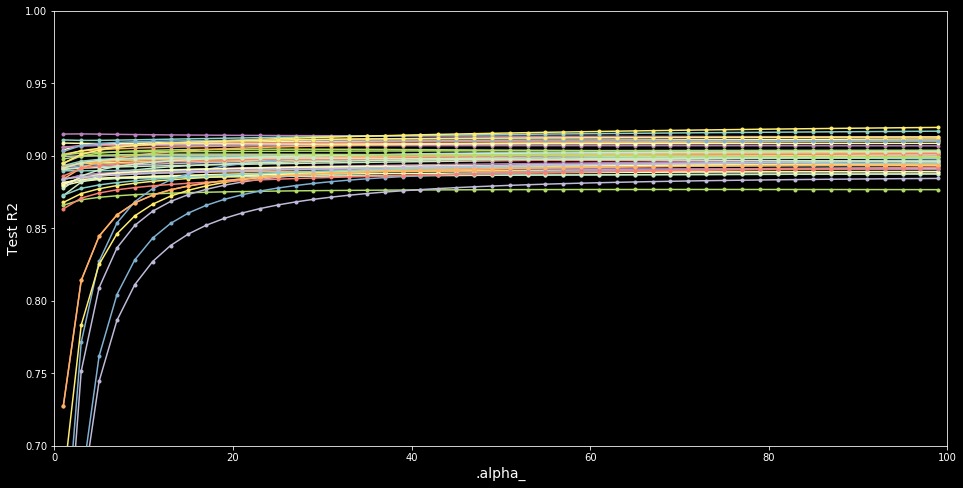

In [455]:
plot_ridge_alphas(500, 50, 100, 2, y_lim=[.7, 1], legend=False)

Let's try to figure out what's going on in one of our stranger splits

In [460]:
# rs = 55
Zs_train, Zs_test, ys_train, ys_test = train_test_split(Z_train, y_train, random_state=55)
ridge_alphas = np.logspace(1,3.5,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Zs_train, ys_train)
ridge_cv.score(Zs_train, ys_train), ridge_cv.score(Zs_test, ys_test), ridge_cv.alpha_

(0.9224745779665597, 0.8790752558973854, 1047.615752789665)

In [463]:
# split with rs55, manual alpha
ridge = Ridge(alpha=80)
ridge.fit(Zs_train, ys_train)
print('a = 80 (manual) | rs = 55')
print('cvs:', cross_val_score(ridge, Zs_train, ys_train, cv=5).mean(), '(mean)')
print('cvs:', cross_val_score(ridge, Zs_train, ys_train, cv=5))

a = 80 (manual) | rs = 55
cvs: 0.8387286109888901 (mean)
cvs: [0.89398185 0.58720217 0.89892521 0.90874217 0.90479165]


Finally, run RidgeCV with our range of interest

In [478]:
ridge_alphas = np.logspace(1.5,1.9,100)
ridge_cv = RidgeCV(alphas=ridge_alphas, scoring='r2', cv=5)
ridge_cv.fit(Z_train, y_train)
ridge_cv.score(Z_train, y_train), ridge_cv.alpha_

(0.9248428950576181, 794.3282347242813)

In [465]:
y_pred = ridge_cv.predict(Z_test)

In [466]:
# create output df
output = pd.DataFrame( {'Id': X_test['Id']} )
output['SalePrice'] = y_pred

output.head()

,Id,SalePrice
0,2658,117991.089654
1,2718,149595.939412
2,2414,222896.101906
3,1989,116851.491535
4,625,186124.565234


In [467]:
#output.to_csv('submissions/submission_33.csv', index=False)